In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_G, ResNet_D
from src.unet import UNet

from src.tools import SumSequential
from src.tools import unfreeze, freeze
from src.tools import weights_init_D, weights_init_G
from src.tools import h5py_to_dataset

from src.tools import get_inverse_stats
from src.fid_score import calculate_frechet_distance
from src.plotters import plot_inv_images, plot_inv_random_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb
from src.tools import fig2data, fig2img # for wandb

## Main Config

In [2]:
DEVICE_IDS = [0,1,2,3]

# DATASET, DATASET_PATH = 'ave_celeba', '../../data/ave_celeba/'
# DATASET, DATASET_PATH = 'celeba', '../../data/celeba_aligned/' # 202k Celeba Images resized to 64x64
# DATASET, DATASET_PATH = 'mnist01', '../../data/'
# DATASET, DATASET_PATH = 'fashionmnist_all', '../../data/'
# DATASET, DATASET_PATH = 'fashionmnist017', '../../data/'
DATASET, DATASET_PATH = 'handbag_shoes_fruit360', '../../data/' # shoes, handbags, fruit360

T_ITERS = 10
D_LR, T_LR = 1e-4, 1e-4


BATCH_SIZE = 64
PLOT_INTERVAL = 200
FD_INTERVAL = 2000
MAX_STEPS = 100001
SEED = 0x000000

SHIFT = True if DATASET == 'ave_celeba' else False # Preprocess the data with shifting means?
EXP_NAME = f'{DATASET}_T{T_ITERS}_{SHIFT}_INV'
INPUT_PATH = '../checkpoints/{}/'.format(DATASET)
OUTPUT_PATH = INPUT_PATH

## Preparation

In [3]:
config = dict(
    DATASET=DATASET, 
    T_ITERS=T_ITERS,
    D_LR=D_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE,
    SHIFT=SHIFT,
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

if DATASET == 'ave_celeba':
    IMG_SIZE, SIZE, NC, Z_DIM = 64, 200000, 3, 128
    ALPHAS = [0.25, 0.5, 0.25]
    CLASSES = [0, 1, 2]
elif DATASET == 'celeba':
    IMG_SIZE, SIZE, NC, Z_DIM = 64, 200000, 3, 128
    ALPHAS = [1.]
    CLASSES = [0]
elif DATASET == 'fashionmnist_all':
    IMG_SIZE, SIZE, NC, Z_DIM = 32, 6000, 1, 16
    ALPHAS = [0.1 for _ in range(10)]
    CLASSES = list(range(10))
elif DATASET == 'fashionmnist017':
    IMG_SIZE, SIZE, NC, Z_DIM = 32, 6000, 1, 16
    ALPHAS = [1/3. for _ in range(3)]
    CLASSES = [0,1,7]
elif DATASET == 'mnist01':
    IMG_SIZE, SIZE, NC, Z_DIM = 32, 6000, 1, 16
    ALPHAS = [0.5, .5]
    CLASSES = [0,1]
elif DATASET == 'handbag_shoes_fruit360':
    IMG_SIZE, SIZE, NC, Z_DIM = 64, 6000, 3, 128
    ALPHAS = [1./3, 1./3, 1./3]
    CLASSES = None
else:
    raise Exception('Unknown dataset')
    
K = len(ALPHAS)
INCEPTION = True if 'celeba' in DATASET else False

## Prepare Samplers (Z, Y)

In [4]:
Z_sampler = distributions.StandardNormalSampler(dim=Z_DIM)
Y_samplers = []

transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(14, fill=(255,255,255)) if DATASET == 'handbag_shoes_fruit360' else torchvision.transforms.Identity(),
    torchvision.transforms.Resize(IMG_SIZE),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: 2 * x - 1)
])

if DATASET != 'handbag_shoes_fruit360': 
    for k in range(K):
        if DATASET in ['ave_celeba', 'celeba']:
            dataset = torchvision.datasets.ImageFolder(DATASET_PATH, transform=transform)
        elif 'fashionmnist' in DATASET:
            dataset = torchvision.datasets.FashionMNIST(root=DATASET_PATH, download=True, transform=transform, train=True)
        elif 'mnist' in DATASET:
            dataset = torchvision.datasets.MNIST(root=DATASET_PATH, download=True, transform=transform)
        else:
            raise Exception('Unknown dataset')

        try:
            dataset.samples = [s for s in dataset.samples if s[1] == CLASSES[k]]
        except:
            idx = [t == CLASSES[k] for t in dataset.targets]
            if 'mnist' in DATASET:
                dataset.targets, dataset.data = np.array(dataset.targets)[idx], torch.tensor(dataset.data)[idx]
            else:
                dataset.targets, dataset.data = np.array(dataset.targets)[idx], np.array(dataset.data)[idx]

        Y_samplers.append(distributions.DatasetSampler(dataset))   
        
elif DATASET == 'handbag_shoes_fruit360':
    dataset = h5py_to_dataset(os.path.join(DATASET_PATH, 'handbag_64.hdf5'))
    Y_samplers.append(distributions.DatasetSampler(dataset))
    dataset = h5py_to_dataset(os.path.join(DATASET_PATH, 'shoes_64.hdf5'))
    Y_samplers.append(distributions.DatasetSampler(dataset))
    dataset = torchvision.datasets.ImageFolder(os.path.join(DATASET_PATH, 'fruit360'), transform=transform)
    Y_samplers.append(distributions.DatasetSampler(dataset))
    
if SHIFT:
    with torch.no_grad():
        Y_bar_mean = 0.
        Y_means = []
        for k in range(K):
            Y_means.append(Y_samplers[k].dataset.mean(dim=0))
            Y_bar_mean += ALPHAS[k] * Y_means[-1]
        for k in range(K):
            Y_samplers[k].dataset += Y_bar_mean - Y_means[k]
    
torch.cuda.empty_cache(); gc.collect()
clear_output()

# Load dataset stats

In [5]:
stats_name = None
if DATASET in ['ave_celeba', 'celeba']:
    stats_name = 'celeba'
elif DATASET == 'fashionmnist_all':
    stats_name = 'fashionmnist_bar'
elif DATASET == 'fashionmnist017':
    stats_name = 'fashionmnist017'
elif DATASET == 'mnist01':
    stats_name = 'mnist01'
elif DATASET == 'handbag_shoes_fruit360':
    pass
else:
    raise Exception('Unknown dataset')

if stats_name is not None:
    with open('../stats/{}.json'.format(stats_name), 'r') as f:
        stats = json.load(f)
        mu_data, sigma_data = stats['mu'], stats['sigma']
        del stats
        gc.collect()
else:
    mu_data, sigma_data = None, None

# Loading Barycenter Generator

In [6]:
G = ResNet_G(Z_DIM, IMG_SIZE, nc=NC).cuda()

if len(DEVICE_IDS) > 1:
    G = nn.DataParallel(G, device_ids=DEVICE_IDS)

G.load_state_dict(torch.load(os.path.join('../checkpoints/{}/'.format(DATASET), 'G.pt')))
freeze(G)

# Initializing Networks

In [7]:
Ds_inv = []
for k in range(K):
    Ds_inv.append(ResNet_D(IMG_SIZE, nc=NC).cuda())
    Ds_inv[-1].apply(weights_init_D)

Ts_inv = []
for k in range(K):
    Ts_inv.append(UNet(NC, NC, base_factor=48 if NC == 3 else 16).cuda())

if len(DEVICE_IDS) > 1:
    for k in range(K):
        Ts_inv[k] = nn.DataParallel(Ts_inv[k], device_ids=DEVICE_IDS)
        Ds_inv[k] = nn.DataParallel(Ds_inv[k], device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in Ts_inv[0].parameters()]))
print('D params:', np.sum([np.prod(p.shape) for p in Ds_inv[0].parameters()]))

T params: 9715827
D params: 22933441


In [8]:
# Fix random images
Z_fixed = Z_sampler.sample(10)
Ys_fixed = [Y_samplers[k].sample(10) for k in range(K)]

### Plots Test

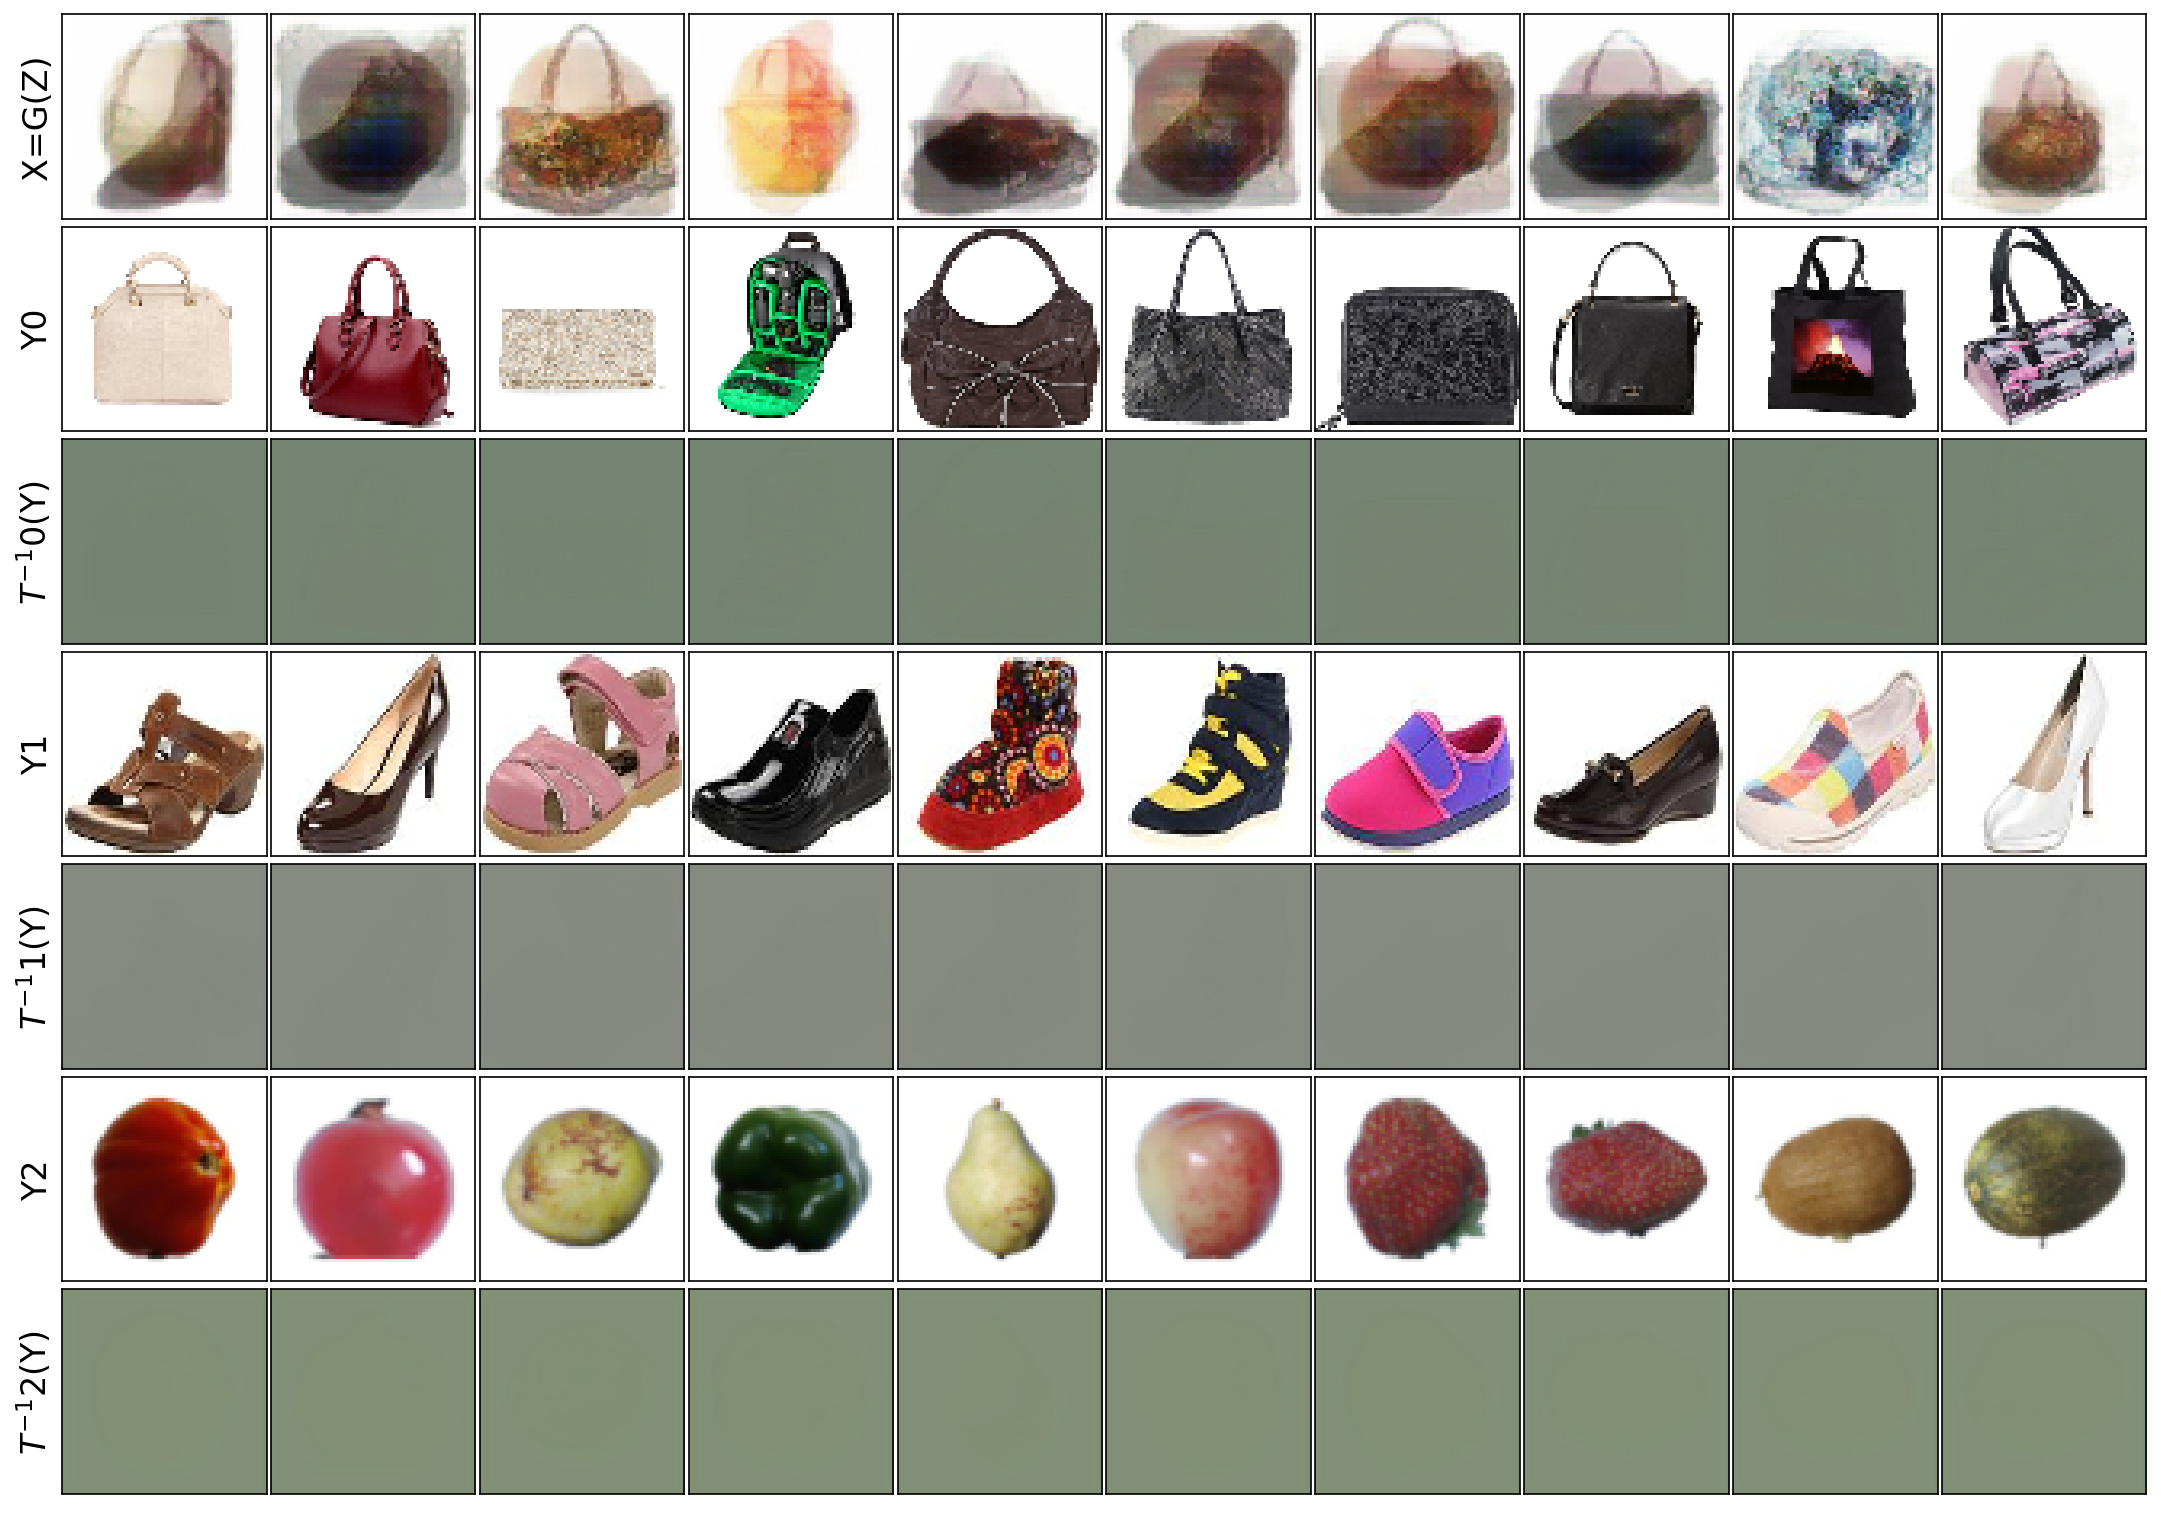

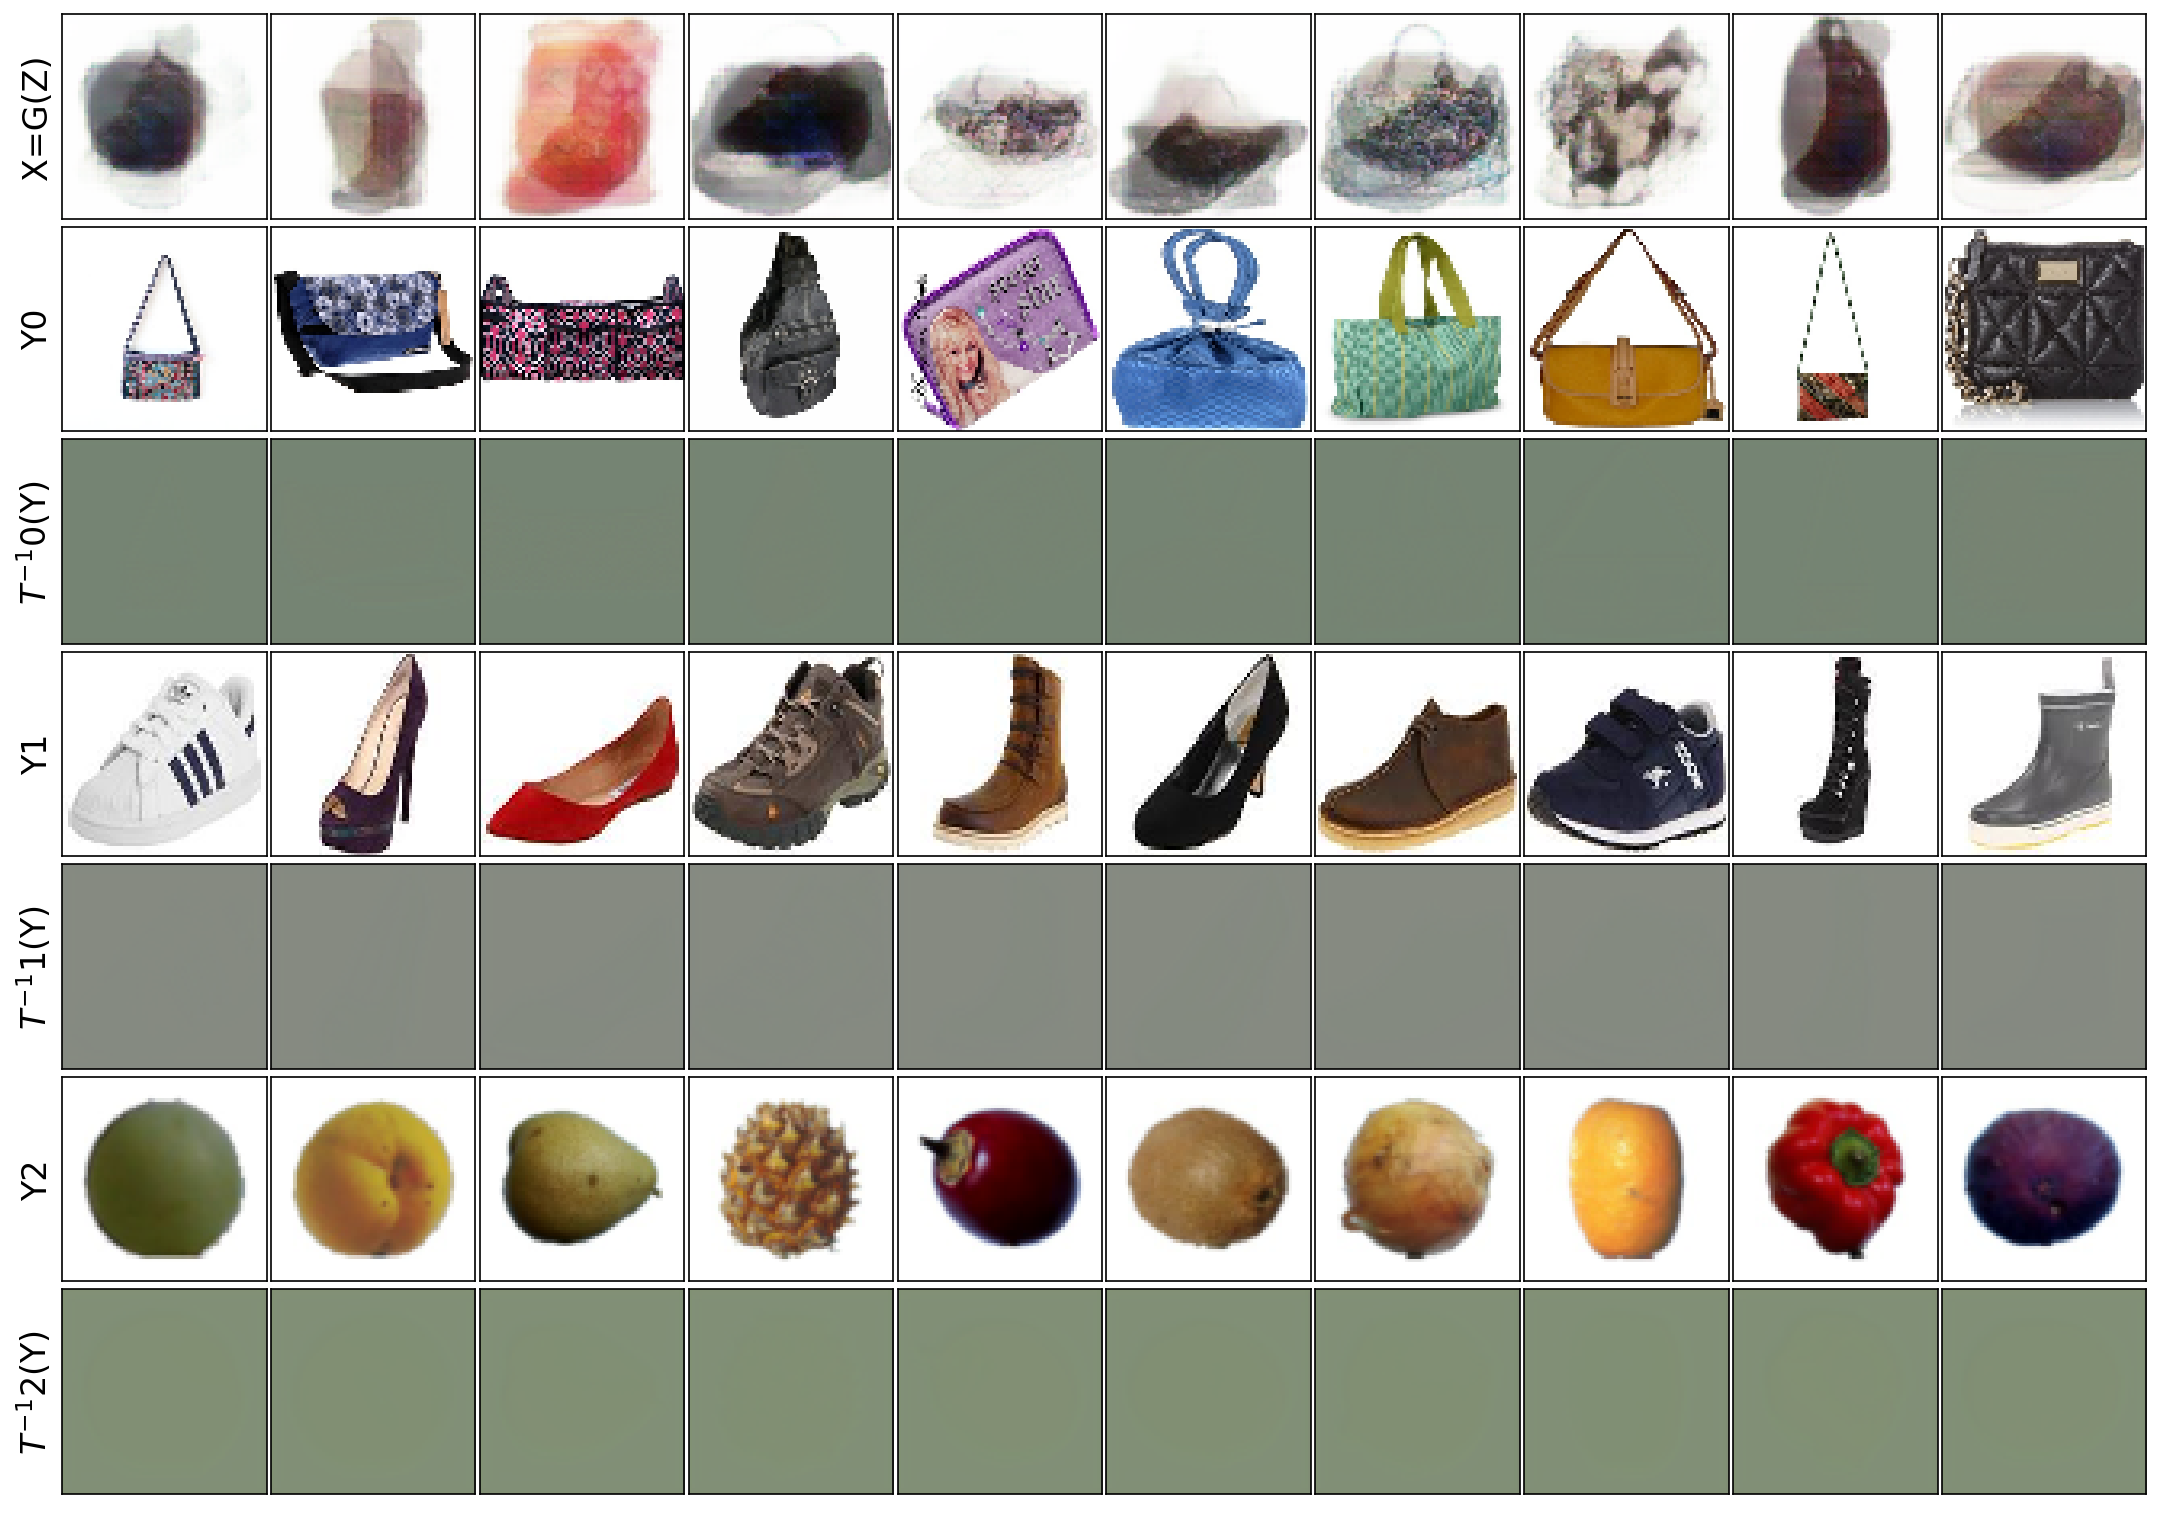

In [9]:
fig, axes = plot_inv_images(Z_fixed, Ys_fixed, G, Ts_inv)
fig, axes = plot_inv_random_images(Z_sampler, Y_samplers, G, Ts_inv)

# Run Training

In [10]:
wandb.init(name=EXP_NAME, project='wasserstein2iterativenetworks', entity='gunsandroses', config=config)
pass

wandb: Currently logged in as: gunsandroses (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [11]:
Ts_inv_opt, Ds_inv_opt = [], []

for k in range(K):
    Ts_inv_opt.append(torch.optim.Adam(Ts_inv[k].parameters(), lr=T_LR, weight_decay=1e-10))
    Ds_inv_opt.append(torch.optim.Adam(Ds_inv[k].parameters(), lr=D_LR, weight_decay=1e-10))

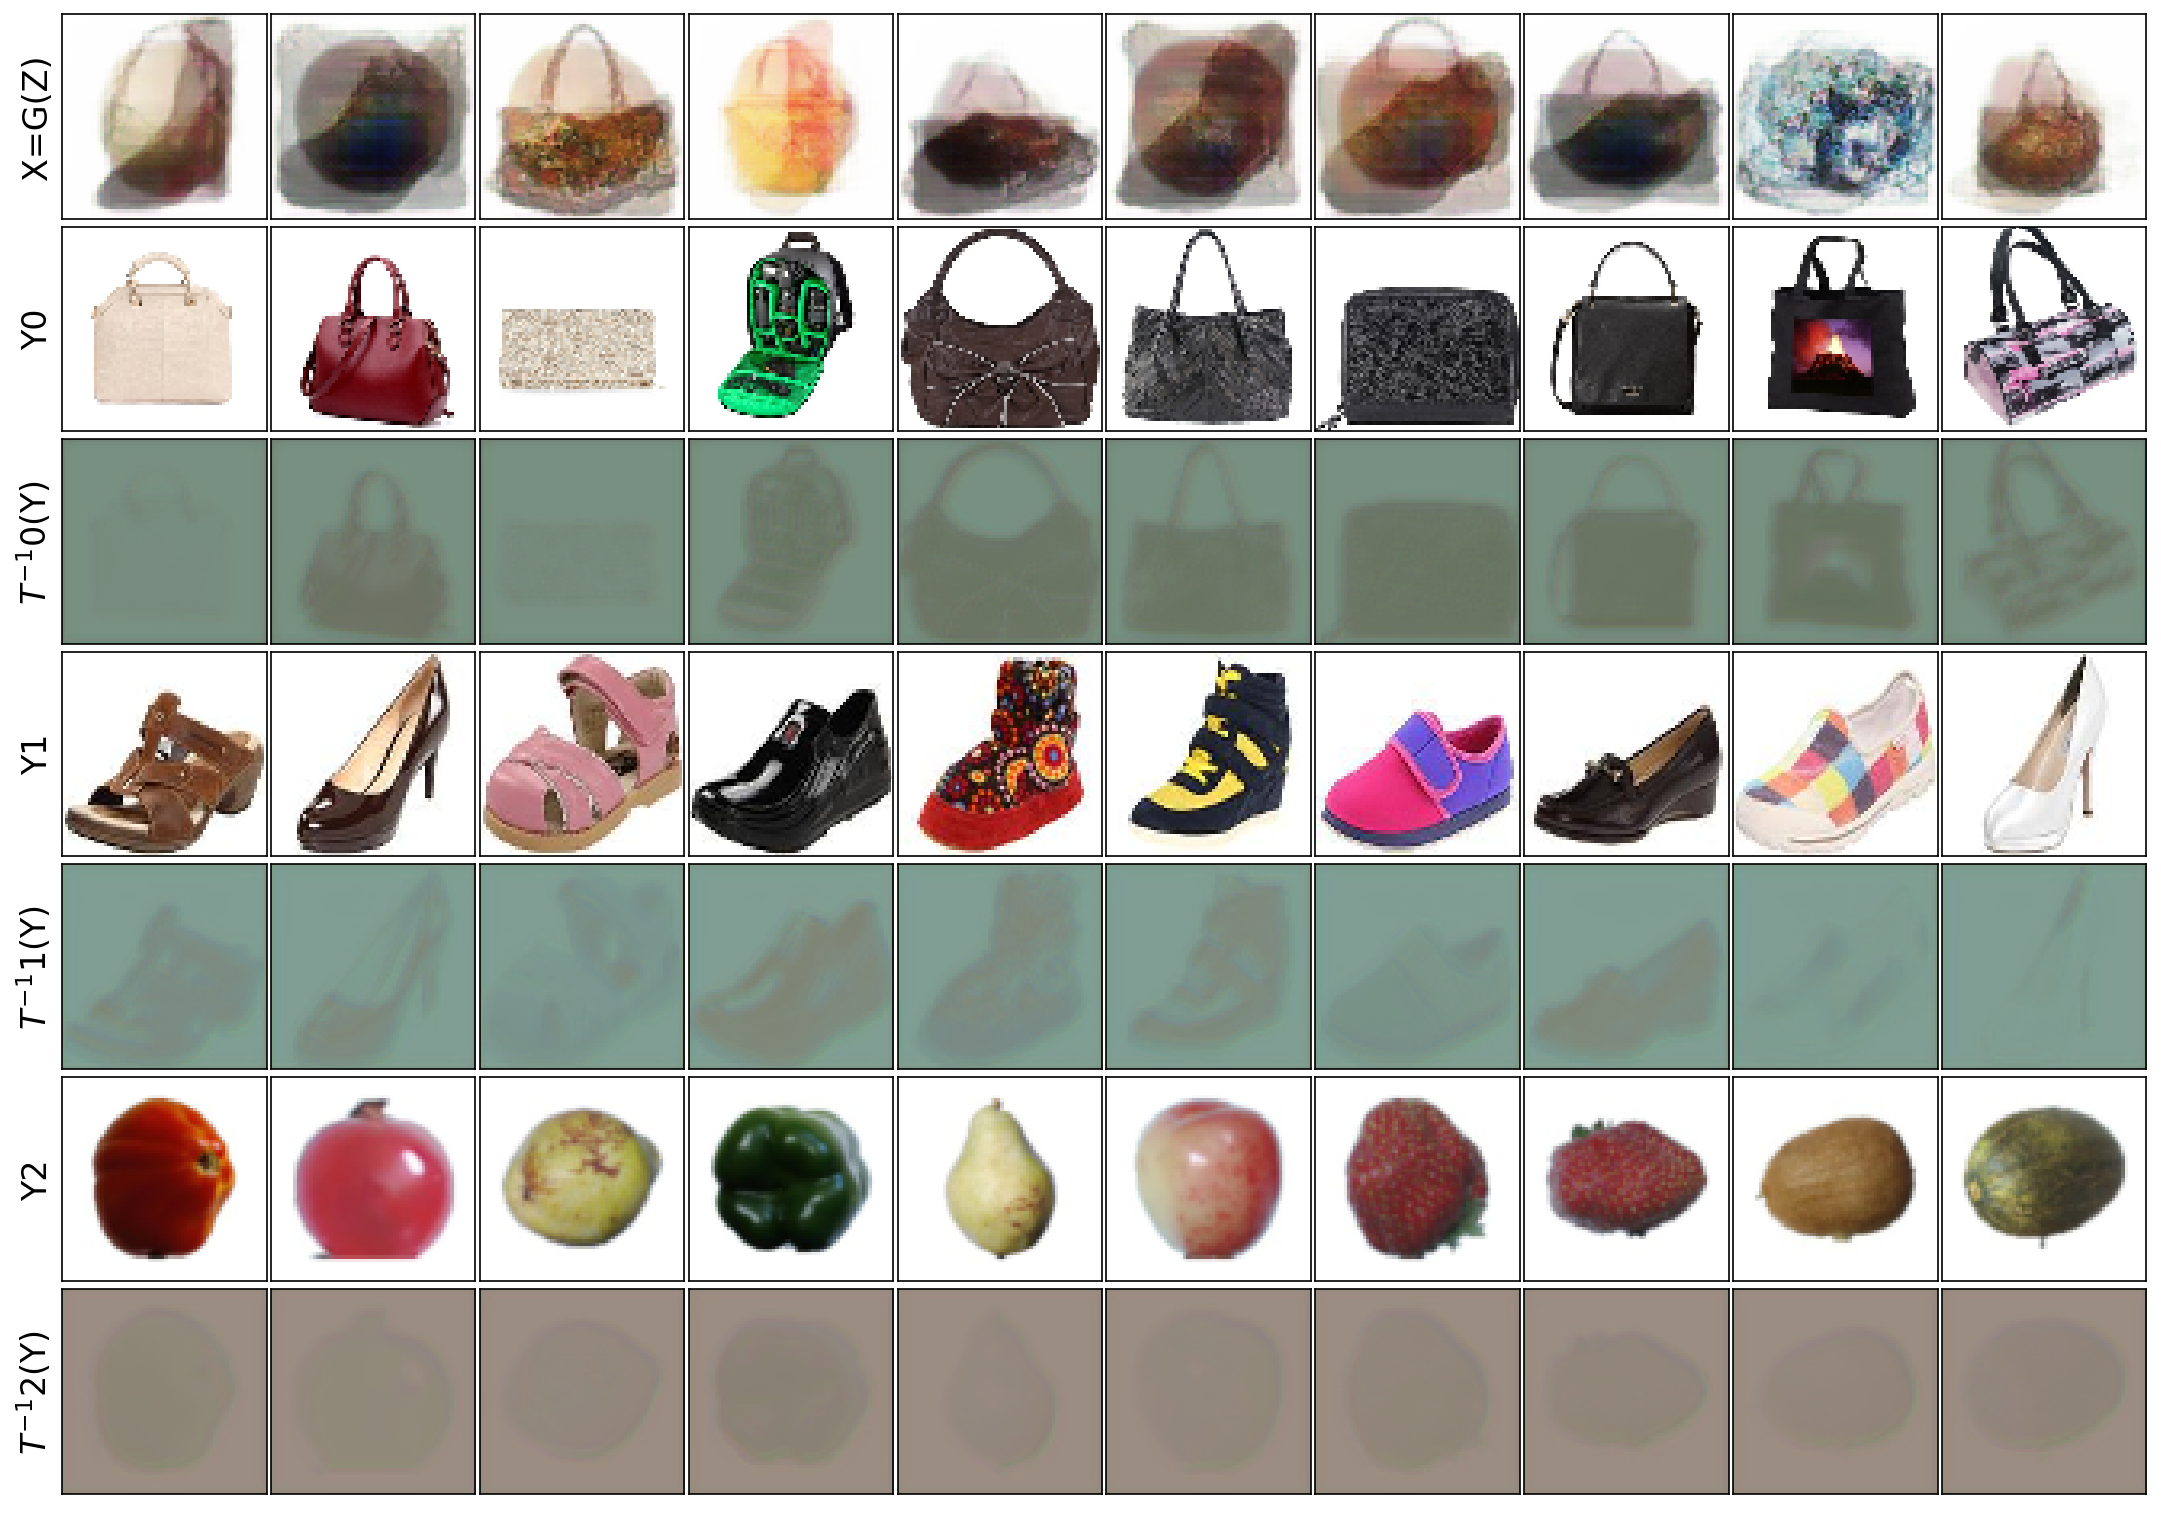

In [ ]:
for step in tqdm(range(MAX_STEPS)):
    for k in range(K):
        # T optimization
        unfreeze(Ts_inv[k]); freeze(Ds_inv[k])
        for t_iter in range(T_ITERS): 
            with torch.no_grad():
                Y = Y_samplers[k].sample(BATCH_SIZE)
            Ts_inv_opt[k].zero_grad()
            T_inv_Y = Ts_inv[k](Y)
            T_inv_loss = .5 * F.mse_loss(Y, T_inv_Y) - Ds_inv[k](T_inv_Y).mean()
            T_inv_loss.backward(); Ts_inv_opt[k].step()
        del T_inv_loss, T_inv_Y, Y; gc.collect(); torch.cuda.empty_cache()
        
        # D optimization
        freeze(Ts_inv[k]); unfreeze(Ds_inv[k])
        with torch.no_grad():
            X = G(Z_sampler.sample(BATCH_SIZE))
        Y = Y_samplers[k].sample(BATCH_SIZE)
        unfreeze(Ds_inv[k]); freeze(Ts_inv[k])
        with torch.no_grad():
            T_inv_Y = Ts_inv[k](Y)  
        Ds_inv_opt[k].zero_grad()
        D_inv_loss = Ds_inv[k](T_inv_Y).mean() - Ds_inv[k](X).mean()
        D_inv_loss.backward(); Ds_inv_opt[k].step();
        wandb.log({f'D_loss_{k}' : D_inv_loss.item()}, step=step) 
        del D_inv_loss, Y, X; gc.collect(); torch.cuda.empty_cache()
        
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_inv_images(Z_fixed, Ys_fixed, G, Ts_inv)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_inv_random_images(Z_sampler, Y_samplers, G, Ts_inv)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    
    if step % FD_INTERVAL == FD_INTERVAL - 1:
        if mu_data is not None:
            print('Computing FD score')
            mus, sigmas = get_inverse_stats(Ts_inv, Y_samplers, inception=INCEPTION, batch_size=8, verbose=True)
            FIDs_T_inv = [calculate_frechet_distance(mus[k], sigmas[k], mu_data, sigma_data) for k in range(K)]
            del mus, sigmas;  gc.collect(); torch.cuda.empty_cache()
            
            wandb.log({f'FD_T_inv_{k}' : FIDs_T_inv[k] for k in range(K)}, step=step)
        
        print('Creating a checkpoint')
        for k in range(K):
            freeze(Ts_inv[k]); 
            torch.save(Ts_inv[k].state_dict(), os.path.join(OUTPUT_PATH, f'T_inv_{k}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()